## DQN train notebook

In [1]:
import numpy as np
from cube import Cube
from tqdm import tqdm
from q_network import QNetwork
import torch
from copy import deepcopy
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
episodes = 10000
episode_len = 5
scramble_steps = 1

lr = 0.0001
buffer_size = 10000
batch_len = 32
gamma = 0.9
epsilon = 0.1
target_update_interval = 100
learning_starts = 100

avg_interval = 25

In [3]:
Q_net = QNetwork().to(device)
Q_net.train()

Q_target_net = deepcopy(Q_net)

optim = torch.optim.SGD(Q_net.parameters(), lr = lr)

replay_buffer = []

In [4]:
action_encode = {
    'F': 0,
    'F\'': 1,
    'B' : 2,
    'B\'': 3,
    'L' : 4,
    'L\'': 5,
    'R' : 6,
    'R\'': 7,
    'U' : 8,
    'U\'': 9,
    'D' : 10,
    'D\'': 11,
}
action_decode = {encoding : action for action, encoding in action_encode.items()}

def normalize_state(state):
    return (state - 2.5) / 2.5

In [5]:
iters_since_target_update = 0
it = 0
eps_since_last_avg = 0
ep_average_reward = 0
ep_average_loss = 0
ep_average_rewards = []
ep_average_losses = []
for ep in tqdm(range(episodes)):
    cube = Cube()
    cube.scramble(scramble_steps)
    s = np.copy(cube.facelets)
    
    for i in range(episode_len):
        with torch.no_grad():
            Q_pred = Q_net(torch.Tensor(normalize_state(s))[None, :].to(device))
        
        a = torch.argmax(Q_pred).item()
        if np.random.uniform() < epsilon:
            a = np.random.randint(12)
        
        r = cube.rotate_code_get_reward(action_decode[a])
        s_prime = np.copy(cube.facelets)
        
        replay_buffer.append({'s': s, 'a': a, 'r': r, 's_prime': s_prime})
        if len(replay_buffer) > buffer_size:
            replay_buffer.pop(0)
        
        s = s_prime
        it += 1
        
        if it >= learning_starts:
            batch = np.random.choice(replay_buffer, batch_len, replace = False)
            batch_s = np.array([x['s'] for x in batch])
            batch_a = np.array([x['a'] for x in batch])
            batch_r = np.array([x['r'] for x in batch])
            batch_r = torch.Tensor(batch_r).to(device)
            batch_s_prime = np.array([x['s_prime'] for x in batch])
            
            Q_hat = Q_net(torch.Tensor(normalize_state(batch_s)).to(device))[range(batch_len), torch.Tensor(batch_a).to(device).long()]
            
            with torch.no_grad():
                Q_target = batch_r + gamma * torch.max(Q_target_net(torch.Tensor(normalize_state(batch_s_prime)).to(device)), axis = 1).values
                for j in range(batch_len):
                    if cube.is_solved_state(batch_s_prime[j]):
                        Q_target[j] = batch_r[j]
            
            optim.zero_grad()
            loss = torch.nn.MSELoss()(Q_hat, Q_target)
            # print(loss)
            loss.backward()
            
            optim.step()
            
            iters_since_target_update += 1
            if iters_since_target_update >= target_update_interval:
                Q_target_net = deepcopy(Q_net)
                iters_since_target_update = 0
            
            ep_average_reward += r
            ep_average_loss += loss.item()
            # print("LOSS",loss.item())
        
        if cube.is_solved_state(s):
            break
            
    eps_since_last_avg += 1
    if eps_since_last_avg >= avg_interval:
        ep_average_rewards.append(ep_average_reward / avg_interval)
        ep_average_losses.append(ep_average_loss / avg_interval)
        print(ep_average_losses[-1])
        ep_average_reward = 0
        ep_average_loss = 0
        eps_since_last_avg = 0

  0%|          | 29/10000 [00:03<13:28, 12.34it/s] 

359.78837036132813


  1%|          | 55/10000 [00:03<05:49, 28.47it/s]

3312.4045080566407


  1%|          | 80/10000 [00:04<04:18, 38.43it/s]

3334.4714715576174


  1%|          | 105/10000 [00:05<03:44, 44.03it/s]

2673.5632379150393


  1%|▏         | 130/10000 [00:05<03:53, 42.24it/s]

2676.863985595703


  2%|▏         | 156/10000 [00:06<03:46, 43.48it/s]

2310.56971862793


  2%|▏         | 182/10000 [00:06<03:34, 45.76it/s]

2229.936188964844


  2%|▏         | 209/10000 [00:07<03:27, 47.16it/s]

2287.7463439941407


  2%|▏         | 229/10000 [00:07<03:39, 44.55it/s]

2594.1976098632813


  3%|▎         | 260/10000 [00:08<03:25, 47.45it/s]

2557.883525695801


  3%|▎         | 280/10000 [00:09<03:44, 43.31it/s]

2332.298260498047


  3%|▎         | 307/10000 [00:09<03:36, 44.85it/s]

2358.8874713134765


  3%|▎         | 332/10000 [00:10<03:32, 45.53it/s]

2488.663798828125


  4%|▎         | 359/10000 [00:10<03:32, 45.29it/s]

2471.2146264648436


  4%|▍         | 379/10000 [00:11<03:45, 42.68it/s]

2320.4089181518557


  4%|▍         | 405/10000 [00:11<03:39, 43.79it/s]

2596.4269161987304


  4%|▍         | 430/10000 [00:12<03:36, 44.29it/s]

2461.9578326416017


  5%|▍         | 456/10000 [00:13<03:42, 42.92it/s]

2478.8316583251953


  5%|▍         | 480/10000 [00:13<03:43, 42.67it/s]

2742.167564697266


  5%|▌         | 505/10000 [00:14<03:36, 43.80it/s]

2620.0712103271485


  5%|▌         | 532/10000 [00:14<03:10, 49.82it/s]

2475.605797729492


  6%|▌         | 554/10000 [00:15<03:25, 45.98it/s]

2344.3542663574217


  6%|▌         | 580/10000 [00:15<03:30, 44.72it/s]

2674.7619885253907


  6%|▌         | 607/10000 [00:16<03:21, 46.73it/s]

2810.9422705078123


  6%|▋         | 630/10000 [00:16<03:03, 51.05it/s]

2651.3486810302734


  7%|▋         | 654/10000 [00:17<03:12, 48.64it/s]

2531.254992675781


  7%|▋         | 679/10000 [00:18<03:41, 42.17it/s]

3134.5014526367186


  7%|▋         | 707/10000 [00:18<03:11, 48.54it/s]

2669.584403076172


  7%|▋         | 732/10000 [00:19<03:31, 43.90it/s]

2910.8732891845702


  8%|▊         | 759/10000 [00:19<03:22, 45.66it/s]

2744.699871826172


  8%|▊         | 779/10000 [00:20<03:38, 42.28it/s]

2746.8521014404296


  8%|▊         | 805/10000 [00:20<03:16, 46.69it/s]

2353.7288067626955


  8%|▊         | 830/10000 [00:21<03:25, 44.62it/s]

2426.411514892578


  9%|▊         | 857/10000 [00:22<03:10, 48.00it/s]

2185.3526544189453


  9%|▉         | 882/10000 [00:22<03:22, 44.92it/s]

1920.3303393554688


  9%|▉         | 904/10000 [00:23<03:33, 42.60it/s]

1979.182525024414


  9%|▉         | 930/10000 [00:23<03:38, 41.54it/s]

1991.0858892822266


 10%|▉         | 955/10000 [00:24<03:24, 44.28it/s]

2203.813854980469


 10%|▉         | 982/10000 [00:24<03:31, 42.71it/s]

1915.4669787597657


 10%|█         | 1005/10000 [00:25<03:09, 47.38it/s]

1552.0214511108397


 10%|█         | 1034/10000 [00:25<03:04, 48.73it/s]

1141.1551184082032


 11%|█         | 1059/10000 [00:26<03:01, 49.15it/s]

1069.1018786621094


 11%|█         | 1080/10000 [00:26<03:22, 43.99it/s]

1163.8146896362305


 11%|█         | 1105/10000 [00:27<02:43, 54.37it/s]

1086.010914916992


 11%|█▏        | 1129/10000 [00:27<03:10, 46.61it/s]

1142.750615234375


 12%|█▏        | 1155/10000 [00:28<03:20, 44.20it/s]

1137.5154794311522


 12%|█▏        | 1183/10000 [00:29<03:08, 46.76it/s]

824.4823104858399


 12%|█▏        | 1204/10000 [00:29<03:21, 43.69it/s]

760.5386883544921


 12%|█▏        | 1235/10000 [00:30<03:12, 45.49it/s]

908.4524145507812


 13%|█▎        | 1257/10000 [00:30<03:17, 44.18it/s]

966.4353564453126


 13%|█▎        | 1278/10000 [00:31<03:12, 45.40it/s]

1477.6413372802735


 13%|█▎        | 1307/10000 [00:31<02:55, 49.48it/s]

974.2067794799805


 13%|█▎        | 1329/10000 [00:32<03:08, 45.94it/s]

624.4962054443359


 14%|█▎        | 1355/10000 [00:33<03:27, 41.60it/s]

745.8550341796876


 14%|█▍        | 1385/10000 [00:33<02:41, 53.31it/s]

654.2764974975586


 14%|█▍        | 1410/10000 [00:34<02:37, 54.43it/s]

715.7815133666992


 14%|█▍        | 1435/10000 [00:34<02:27, 57.94it/s]

580.3794846343994


 15%|█▍        | 1459/10000 [00:35<02:42, 52.63it/s]

573.9257095336914


 15%|█▍        | 1483/10000 [00:35<02:46, 51.02it/s]

645.8121116638183


 15%|█▌        | 1510/10000 [00:35<02:29, 56.90it/s]

648.8307849121094


 15%|█▌        | 1534/10000 [00:36<02:02, 69.16it/s]

838.5377163696289


 16%|█▌        | 1556/10000 [00:36<02:02, 68.78it/s]

536.0179586791992


 16%|█▌        | 1586/10000 [00:37<02:10, 64.59it/s]

600.4415075683594


 16%|█▌        | 1607/10000 [00:37<02:17, 61.10it/s]

543.8972575378418


 16%|█▋        | 1636/10000 [00:37<02:10, 63.86it/s]

406.73290374755857


 17%|█▋        | 1656/10000 [00:38<02:36, 53.23it/s]

489.3921337890625


 17%|█▋        | 1683/10000 [00:38<02:27, 56.50it/s]

588.6315280151367


 17%|█▋        | 1707/10000 [00:39<02:05, 65.88it/s]

588.0563537597657


 17%|█▋        | 1741/10000 [00:39<01:45, 78.26it/s]

428.2382962036133


 18%|█▊        | 1757/10000 [00:39<01:56, 70.93it/s]

310.3218441772461


 18%|█▊        | 1781/10000 [00:40<02:26, 56.03it/s]

435.68341873168947


 18%|█▊        | 1810/10000 [00:40<02:07, 64.02it/s]

383.109617767334


 18%|█▊        | 1835/10000 [00:41<01:55, 70.79it/s]

513.4887696838379


 19%|█▊        | 1859/10000 [00:41<02:06, 64.58it/s]

343.7386483764648


 19%|█▉        | 1880/10000 [00:41<02:12, 61.06it/s]

686.011467590332


 19%|█▉        | 1912/10000 [00:42<01:57, 69.05it/s]

337.76657440185545


 19%|█▉        | 1935/10000 [00:42<02:06, 63.55it/s]

316.4712255859375


 20%|█▉        | 1964/10000 [00:43<02:01, 66.15it/s]

434.67417510986326


 20%|█▉        | 1985/10000 [00:43<02:12, 60.66it/s]

374.58797637939455


 20%|██        | 2009/10000 [00:43<01:56, 68.82it/s]

304.14316360473634


 20%|██        | 2035/10000 [00:44<01:51, 71.19it/s]

347.49910614013675


 21%|██        | 2060/10000 [00:44<01:52, 70.88it/s]

327.71068435668946


 21%|██        | 2082/10000 [00:44<02:23, 55.27it/s]

689.2466278076172


 21%|██        | 2108/10000 [00:45<02:20, 56.16it/s]

1090.9714321899414


 21%|██▏       | 2137/10000 [00:45<02:08, 61.20it/s]

261.3579104614258


 22%|██▏       | 2155/10000 [00:46<01:50, 70.84it/s]

404.95775680541993


 22%|██▏       | 2184/10000 [00:46<02:05, 62.38it/s]

522.8001467895508


 22%|██▏       | 2211/10000 [00:47<02:12, 58.87it/s]

405.54455154418946


 22%|██▏       | 2234/10000 [00:47<02:05, 61.91it/s]

330.6987212371826


 23%|██▎       | 2256/10000 [00:47<02:04, 61.99it/s]

463.4099769592285


 23%|██▎       | 2287/10000 [00:48<01:57, 65.65it/s]

198.7558154296875


 23%|██▎       | 2309/10000 [00:48<02:02, 62.83it/s]

238.9658004760742


 23%|██▎       | 2338/10000 [00:49<02:02, 62.33it/s]

245.60486778259278


 24%|██▎       | 2360/10000 [00:49<02:06, 60.60it/s]

205.06448944091798


 24%|██▍       | 2382/10000 [00:49<02:03, 61.86it/s]

223.96899536132813


 24%|██▍       | 2413/10000 [00:50<01:46, 70.97it/s]

177.9863394165039


 24%|██▍       | 2431/10000 [00:50<01:45, 71.56it/s]

167.35601379394532


 25%|██▍       | 2464/10000 [00:50<01:42, 73.72it/s]

198.92879043579103


 25%|██▍       | 2486/10000 [00:51<02:02, 61.40it/s]

265.93094024658205


 25%|██▌       | 2506/10000 [00:51<02:07, 58.68it/s]

244.13884658813475


 25%|██▌       | 2534/10000 [00:52<01:54, 64.98it/s]

194.29353164672852


 26%|██▌       | 2563/10000 [00:52<01:58, 62.76it/s]

190.3322830963135


 26%|██▌       | 2585/10000 [00:52<02:03, 60.02it/s]

181.57245330810548


 26%|██▌       | 2607/10000 [00:53<01:52, 65.55it/s]

176.85898345947265


 26%|██▋       | 2637/10000 [00:53<01:58, 61.95it/s]

194.87189666748046


 27%|██▋       | 2662/10000 [00:54<01:43, 70.78it/s]

189.74490074157714


 27%|██▋       | 2690/10000 [00:54<01:35, 76.16it/s]

135.5031558227539


 27%|██▋       | 2714/10000 [00:54<01:38, 73.73it/s]

131.33047203063964


 27%|██▋       | 2736/10000 [00:55<01:58, 61.37it/s]

163.42325759887694


 28%|██▊       | 2768/10000 [00:55<01:41, 71.27it/s]

191.5146263885498


 28%|██▊       | 2783/10000 [00:56<01:59, 60.44it/s]

169.33854469299317


 28%|██▊       | 2807/10000 [00:56<01:50, 64.92it/s]

205.79541664123536


 28%|██▊       | 2834/10000 [00:56<02:06, 56.62it/s]

211.7796516418457


 29%|██▊       | 2856/10000 [00:57<02:08, 55.48it/s]

148.81440208435058


 29%|██▉       | 2884/10000 [00:57<02:02, 57.95it/s]

145.62296882629394


 29%|██▉       | 2914/10000 [00:58<01:43, 68.29it/s]

140.05332633972168


 29%|██▉       | 2937/10000 [00:58<01:52, 63.05it/s]

159.503101272583


 30%|██▉       | 2960/10000 [00:58<01:42, 68.52it/s]

112.53142375946045


 30%|██▉       | 2981/10000 [00:59<01:56, 60.25it/s]

156.00849670410156


 30%|███       | 3015/10000 [00:59<01:34, 74.07it/s]

126.06262519836426


 30%|███       | 3039/10000 [01:00<01:34, 73.63it/s]

120.0075569152832


 31%|███       | 3055/10000 [01:00<01:47, 64.53it/s]

153.7134432220459


 31%|███       | 3087/10000 [01:00<01:39, 69.39it/s]

152.75045959472655


 31%|███       | 3110/10000 [01:01<01:48, 63.45it/s]

115.40685401916504


 31%|███▏      | 3137/10000 [01:01<01:50, 62.27it/s]

167.68328582763672


 32%|███▏      | 3158/10000 [01:02<01:55, 59.47it/s]

162.19897331237792


 32%|███▏      | 3181/10000 [01:02<01:45, 64.44it/s]

140.56059684753419


 32%|███▏      | 3213/10000 [01:02<01:38, 68.61it/s]

124.26962409973144


 32%|███▏      | 3235/10000 [01:03<01:42, 66.25it/s]

136.52326110839843


 33%|███▎      | 3255/10000 [01:03<02:04, 54.07it/s]

170.3972716522217


 33%|███▎      | 3281/10000 [01:04<01:58, 56.88it/s]

158.81026603698731


 33%|███▎      | 3310/10000 [01:04<01:42, 65.37it/s]

127.92635108947754


 33%|███▎      | 3334/10000 [01:04<01:57, 56.87it/s]

121.11601734161377


 34%|███▎      | 3360/10000 [01:05<01:36, 68.52it/s]

152.31080459594727


 34%|███▍      | 3385/10000 [01:05<01:40, 65.95it/s]

146.51402053833007


 34%|███▍      | 3412/10000 [01:06<01:39, 66.18it/s]

84.82656463623047


 34%|███▍      | 3437/10000 [01:06<01:27, 74.85it/s]

113.39233867645264


 35%|███▍      | 3460/10000 [01:06<01:38, 66.42it/s]

112.75660705566406


 35%|███▍      | 3483/10000 [01:07<01:32, 70.64it/s]

105.05640312194824


 35%|███▌      | 3512/10000 [01:07<01:50, 58.83it/s]

138.16940475463866


 35%|███▌      | 3531/10000 [01:08<02:05, 51.74it/s]

134.94228488922118


 36%|███▌      | 3563/10000 [01:08<01:30, 70.77it/s]

100.10480075836182


 36%|███▌      | 3586/10000 [01:08<01:44, 61.46it/s]

98.92231349945068


 36%|███▌      | 3608/10000 [01:09<01:49, 58.44it/s]

95.12244453430176


 36%|███▋      | 3634/10000 [01:09<01:53, 56.14it/s]

133.92993221282958


 37%|███▋      | 3659/10000 [01:10<01:56, 54.33it/s]

113.85110637664795


 37%|███▋      | 3687/10000 [01:10<01:42, 61.37it/s]

129.77719718933105


 37%|███▋      | 3708/10000 [01:11<01:44, 60.13it/s]

91.82229221343994


 37%|███▋      | 3733/10000 [01:11<01:56, 53.59it/s]

110.80528137207031


 38%|███▊      | 3762/10000 [01:11<01:35, 65.02it/s]

107.15835494995117


 38%|███▊      | 3785/10000 [01:12<01:28, 70.10it/s]

73.65820205688476


 38%|███▊      | 3807/10000 [01:12<01:40, 61.42it/s]

95.89632942199707


 38%|███▊      | 3834/10000 [01:13<01:41, 60.72it/s]

106.84510265350342


 39%|███▊      | 3855/10000 [01:13<01:56, 52.64it/s]

89.47146003723145


 39%|███▉      | 3883/10000 [01:13<01:34, 64.54it/s]

111.90394203186035


 39%|███▉      | 3904/10000 [01:14<01:41, 59.77it/s]

89.77757972717285


 39%|███▉      | 3936/10000 [01:14<01:47, 56.35it/s]

137.59040153503418


 40%|███▉      | 3959/10000 [01:15<01:37, 61.72it/s]

81.4592505645752


 40%|███▉      | 3980/10000 [01:15<01:48, 55.50it/s]

105.34493034362794


 40%|████      | 4010/10000 [01:16<01:38, 60.60it/s]

118.6310057067871


 40%|████      | 4032/10000 [01:16<01:33, 63.96it/s]

78.30861003875732


 41%|████      | 4060/10000 [01:16<01:32, 64.49it/s]

105.03270877838135


 41%|████      | 4081/10000 [01:17<01:42, 57.88it/s]

82.62964893341065


 41%|████      | 4109/10000 [01:17<01:34, 62.42it/s]

97.42634243011474


 41%|████▏     | 4131/10000 [01:18<01:38, 59.29it/s]

90.39068439483643


 42%|████▏     | 4162/10000 [01:18<01:23, 69.76it/s]

94.72083862304687


 42%|████▏     | 4184/10000 [01:19<01:35, 60.97it/s]

69.69685684204102


 42%|████▏     | 4212/10000 [01:19<01:34, 61.23it/s]

101.04306861877441


 42%|████▏     | 4231/10000 [01:19<01:57, 48.92it/s]

84.7928458404541


 43%|████▎     | 4259/10000 [01:20<01:48, 52.80it/s]

79.90687999725341


 43%|████▎     | 4281/10000 [01:20<01:37, 58.64it/s]

94.40923957824707


 43%|████▎     | 4308/10000 [01:21<01:46, 53.36it/s]

98.25826816558838


 43%|████▎     | 4334/10000 [01:21<01:46, 53.32it/s]

121.90341430664063


 44%|████▎     | 4356/10000 [01:22<01:33, 60.58it/s]

73.88398891448975


 44%|████▍     | 4385/10000 [01:22<01:39, 56.62it/s]

99.13767574310303


 44%|████▍     | 4407/10000 [01:22<01:29, 62.39it/s]

91.84877841949464


 44%|████▍     | 4436/10000 [01:23<01:32, 60.18it/s]

79.43515634536743


 45%|████▍     | 4455/10000 [01:23<01:44, 52.81it/s]

97.20394973754883


 45%|████▍     | 4483/10000 [01:24<01:33, 59.25it/s]

83.14526515960694


 45%|████▌     | 4512/10000 [01:24<01:27, 63.02it/s]

79.5180670928955


 45%|████▌     | 4533/10000 [01:25<01:29, 61.06it/s]

73.05360843658447


 46%|████▌     | 4554/10000 [01:25<01:39, 54.47it/s]

74.67527088165284


 46%|████▌     | 4586/10000 [01:26<01:34, 57.49it/s]

97.28693325042724


 46%|████▌     | 4608/10000 [01:26<01:42, 52.74it/s]

51.47037969589233


 46%|████▋     | 4632/10000 [01:26<01:21, 66.18it/s]

63.09421504974365


 47%|████▋     | 4653/10000 [01:27<01:41, 52.63it/s]

67.56250316619872


 47%|████▋     | 4686/10000 [01:27<01:34, 56.44it/s]

63.55419605255127


 47%|████▋     | 4705/10000 [01:28<01:48, 48.94it/s]

67.90140697479248


 47%|████▋     | 4730/10000 [01:28<01:40, 52.27it/s]

65.98505420684815


 48%|████▊     | 4753/10000 [01:29<01:59, 43.79it/s]

92.37405729293823


 48%|████▊     | 4784/10000 [01:29<01:36, 54.29it/s]

90.76355281829834


 48%|████▊     | 4810/10000 [01:30<01:34, 54.69it/s]

72.70629945755005


 48%|████▊     | 4837/10000 [01:30<01:29, 57.41it/s]

69.19415336608887


 49%|████▊     | 4862/10000 [01:31<01:29, 57.13it/s]

67.57119548797607


 49%|████▉     | 4881/10000 [01:31<01:30, 56.86it/s]

73.08344207763672


 49%|████▉     | 4907/10000 [01:32<01:39, 51.34it/s]

72.4063370513916


 49%|████▉     | 4928/10000 [01:32<01:24, 59.94it/s]

71.6939086151123


 50%|████▉     | 4962/10000 [01:33<01:28, 57.20it/s]

85.78833068847656


 50%|████▉     | 4980/10000 [01:33<01:31, 54.64it/s]

65.28934368133545


 50%|█████     | 5006/10000 [01:33<01:27, 57.08it/s]

57.496700038909914


 50%|█████     | 5032/10000 [01:34<01:27, 56.98it/s]

69.95044010162354


 51%|█████     | 5056/10000 [01:34<01:34, 52.23it/s]

70.77820423126221


 51%|█████     | 5082/10000 [01:35<01:28, 55.30it/s]

81.60384216308594


 51%|█████     | 5107/10000 [01:35<01:33, 52.39it/s]

66.88275707244873


 51%|█████▏    | 5133/10000 [01:36<01:32, 52.38it/s]

65.041676902771


 52%|█████▏    | 5159/10000 [01:36<01:24, 57.61it/s]

78.11506551742553


 52%|█████▏    | 5183/10000 [01:37<01:41, 47.28it/s]

76.18056671142578


 52%|█████▏    | 5207/10000 [01:37<01:41, 47.23it/s]

69.93935321807861


 52%|█████▏    | 5234/10000 [01:38<01:33, 50.73it/s]

61.17276979446411


 53%|█████▎    | 5258/10000 [01:38<01:31, 52.06it/s]

81.3049876022339


 53%|█████▎    | 5289/10000 [01:39<01:12, 64.91it/s]

67.0095665359497


 53%|█████▎    | 5309/10000 [01:39<01:26, 54.31it/s]

47.50621532440186


 53%|█████▎    | 5333/10000 [01:40<01:33, 49.97it/s]

60.415498142242434


 54%|█████▎    | 5359/10000 [01:40<01:23, 55.28it/s]

56.82775360107422


 54%|█████▍    | 5383/10000 [01:41<01:19, 58.08it/s]

60.2546337890625


 54%|█████▍    | 5409/10000 [01:41<01:23, 54.94it/s]

63.14126173019409


 54%|█████▍    | 5433/10000 [01:41<01:07, 67.45it/s]

48.18468662261963


 55%|█████▍    | 5458/10000 [01:42<01:09, 65.34it/s]

50.59350856781006


 55%|█████▍    | 5485/10000 [01:42<01:18, 57.25it/s]

64.56221061706543


 55%|█████▌    | 5511/10000 [01:43<01:20, 55.62it/s]

71.00063041687012


 55%|█████▌    | 5535/10000 [01:43<01:10, 63.00it/s]

50.991328411102295


 56%|█████▌    | 5555/10000 [01:43<01:32, 47.85it/s]

69.92811149597168


 56%|█████▌    | 5581/10000 [01:44<01:22, 53.60it/s]

62.605872344970706


 56%|█████▌    | 5607/10000 [01:44<01:18, 55.80it/s]

68.40443740844727


 56%|█████▋    | 5633/10000 [01:45<01:00, 71.60it/s]

42.91583909988403


 57%|█████▋    | 5657/10000 [01:45<01:03, 68.77it/s]

49.30339588165283


 57%|█████▋    | 5681/10000 [01:45<01:05, 65.68it/s]

46.04248208999634


 57%|█████▋    | 5706/10000 [01:46<01:07, 64.01it/s]

36.07807209014893


 57%|█████▋    | 5733/10000 [01:46<01:15, 56.86it/s]

56.8228084564209


 58%|█████▊    | 5757/10000 [01:47<01:23, 50.78it/s]

63.429153785705566


 58%|█████▊    | 5782/10000 [01:47<01:24, 49.82it/s]

53.848787479400634


 58%|█████▊    | 5807/10000 [01:48<01:16, 54.82it/s]

56.78712490081787


 58%|█████▊    | 5832/10000 [01:48<01:15, 55.00it/s]

56.861439819335935


 59%|█████▊    | 5854/10000 [01:49<01:11, 57.65it/s]

61.91236042022705


 59%|█████▉    | 5884/10000 [01:49<01:05, 63.01it/s]

50.814371528625486


 59%|█████▉    | 5909/10000 [01:50<01:15, 54.38it/s]

70.69308263778686


 59%|█████▉    | 5941/10000 [01:50<00:58, 68.93it/s]

57.44610078811645


 60%|█████▉    | 5955/10000 [01:50<01:01, 65.83it/s]

38.37659114837646


 60%|█████▉    | 5984/10000 [01:51<01:06, 60.75it/s]

52.83314476013184


 60%|██████    | 6010/10000 [01:51<00:53, 74.05it/s]

43.135442447662356


 60%|██████    | 6032/10000 [01:52<01:01, 64.10it/s]

53.80252765655518


 61%|██████    | 6060/10000 [01:52<01:07, 58.69it/s]

67.83261081695557


 61%|██████    | 6082/10000 [01:52<01:01, 63.34it/s]

49.8930414390564


 61%|██████    | 6108/10000 [01:53<01:15, 51.26it/s]

71.09591690063476


 61%|██████▏   | 6134/10000 [01:53<01:04, 59.72it/s]

58.61103677749634


 62%|██████▏   | 6162/10000 [01:54<01:06, 57.61it/s]

47.36726846694946


 62%|██████▏   | 6182/10000 [01:54<01:09, 54.83it/s]

49.490830936431884


 62%|██████▏   | 6203/10000 [01:55<01:04, 58.54it/s]

55.63474937438965


 62%|██████▏   | 6232/10000 [01:55<01:07, 55.86it/s]

53.99053472518921


 63%|██████▎   | 6258/10000 [01:56<01:08, 54.53it/s]

58.54262815475464


 63%|██████▎   | 6284/10000 [01:56<01:10, 52.42it/s]

68.65200233459473


 63%|██████▎   | 6305/10000 [01:57<01:12, 50.90it/s]

59.18967552185059


 63%|██████▎   | 6330/10000 [01:57<01:10, 52.39it/s]

59.06420434951782


 64%|██████▎   | 6359/10000 [01:57<00:59, 61.06it/s]

44.24038063049316


 64%|██████▍   | 6383/10000 [01:58<00:53, 67.15it/s]

50.5053009223938


 64%|██████▍   | 6404/10000 [01:58<00:53, 66.67it/s]

45.04557197570801


 64%|██████▍   | 6435/10000 [01:59<00:59, 59.63it/s]

47.21856628417969


 65%|██████▍   | 6454/10000 [01:59<01:16, 46.22it/s]

59.07099511146546


 65%|██████▍   | 6482/10000 [02:00<01:02, 55.90it/s]

53.670050048828124


 65%|██████▌   | 6510/10000 [02:00<00:59, 58.45it/s]

45.439039039611814


 65%|██████▌   | 6536/10000 [02:01<01:02, 55.85it/s]

48.07462291717529


 66%|██████▌   | 6562/10000 [02:01<00:57, 60.12it/s]

55.997698612213135


 66%|██████▌   | 6577/10000 [02:01<00:56, 60.12it/s]

45.56832557678223


 66%|██████▌   | 6609/10000 [02:02<01:02, 54.00it/s]

57.02111394882202


 66%|██████▋   | 6635/10000 [02:02<00:56, 59.35it/s]

58.61096998214722


 67%|██████▋   | 6658/10000 [02:03<00:52, 63.25it/s]

49.84817922592163


 67%|██████▋   | 6686/10000 [02:03<00:57, 57.96it/s]

63.23595006942749


 67%|██████▋   | 6705/10000 [02:04<00:59, 54.93it/s]

64.40350044250488


 67%|██████▋   | 6737/10000 [02:04<00:54, 59.56it/s]

58.82252866744995


 68%|██████▊   | 6759/10000 [02:05<00:57, 56.00it/s]

61.74608171463013


 68%|██████▊   | 6786/10000 [02:05<00:54, 58.87it/s]

57.01442583084106


 68%|██████▊   | 6807/10000 [02:05<00:53, 59.56it/s]

54.8711102771759


 68%|██████▊   | 6831/10000 [02:06<01:03, 50.11it/s]

60.4421994972229


 69%|██████▊   | 6862/10000 [02:06<00:49, 63.00it/s]

47.88064119338989


 69%|██████▉   | 6882/10000 [02:07<00:53, 58.43it/s]

44.526977138519285


 69%|██████▉   | 6909/10000 [02:07<00:50, 61.53it/s]

50.078791332244876


 69%|██████▉   | 6934/10000 [02:08<01:01, 49.83it/s]

67.26229574203491


 70%|██████▉   | 6969/10000 [02:08<00:39, 76.15it/s]

44.64728401184082


 70%|██████▉   | 6986/10000 [02:08<00:40, 73.97it/s]

31.44625352859497


 70%|███████   | 7008/10000 [02:09<00:49, 60.83it/s]

58.31428243637085


 70%|███████   | 7038/10000 [02:09<00:45, 64.87it/s]

43.612953414916994


 71%|███████   | 7057/10000 [02:10<00:54, 54.35it/s]

47.47295087814331


 71%|███████   | 7087/10000 [02:10<00:40, 72.43it/s]

46.47865655899048


 71%|███████   | 7110/10000 [02:10<00:45, 63.68it/s]

38.805804052352904


 71%|███████▏  | 7135/10000 [02:11<00:41, 69.76it/s]

39.01419658660889


 72%|███████▏  | 7157/10000 [02:11<00:50, 56.28it/s]

64.24696104049683


 72%|███████▏  | 7188/10000 [02:12<00:51, 54.50it/s]

70.01226139068604


 72%|███████▏  | 7216/10000 [02:12<00:37, 74.31it/s]

44.492933406829835


 72%|███████▏  | 7231/10000 [02:13<00:43, 64.01it/s]

29.539311237335205


 73%|███████▎  | 7256/10000 [02:13<00:41, 65.40it/s]

50.400307502746585


 73%|███████▎  | 7284/10000 [02:13<00:47, 57.71it/s]

46.389888305664066


 73%|███████▎  | 7313/10000 [02:14<00:41, 64.71it/s]

52.44965623855591


 73%|███████▎  | 7335/10000 [02:14<00:45, 58.11it/s]

51.786313400268554


 74%|███████▎  | 7359/10000 [02:15<00:47, 55.07it/s]

52.664115524291994


 74%|███████▍  | 7389/10000 [02:15<00:39, 65.47it/s]

44.20996122360229


 74%|███████▍  | 7412/10000 [02:15<00:39, 65.68it/s]

40.83952512741089


 74%|███████▍  | 7433/10000 [02:16<00:44, 57.65it/s]

45.59786369323731


 75%|███████▍  | 7460/10000 [02:16<00:43, 57.82it/s]

55.151251745224


 75%|███████▍  | 7480/10000 [02:17<00:41, 60.26it/s]

48.89157876968384


 75%|███████▌  | 7510/10000 [02:17<00:39, 63.51it/s]

45.180140285491944


 75%|███████▌  | 7534/10000 [02:17<00:37, 65.59it/s]

37.58035289764404


 76%|███████▌  | 7555/10000 [02:18<00:40, 61.02it/s]

51.460706596374514


 76%|███████▌  | 7586/10000 [02:18<00:36, 65.67it/s]

46.43876892089844


 76%|███████▌  | 7607/10000 [02:19<00:39, 60.47it/s]

39.41734846115112


 76%|███████▋  | 7635/10000 [02:19<00:40, 58.01it/s]

42.812745304107665


 77%|███████▋  | 7664/10000 [02:20<00:36, 63.92it/s]

50.406275520324705


 77%|███████▋  | 7685/10000 [02:20<00:35, 64.39it/s]

47.98758085250854


 77%|███████▋  | 7709/10000 [02:20<00:36, 62.94it/s]

45.347567291259764


 77%|███████▋  | 7730/10000 [02:21<00:36, 62.57it/s]

47.64724124908447


 78%|███████▊  | 7760/10000 [02:21<00:36, 60.66it/s]

41.794557418823246


 78%|███████▊  | 7782/10000 [02:22<00:38, 57.53it/s]

45.54268585205078


 78%|███████▊  | 7807/10000 [02:22<00:41, 52.95it/s]

54.47605484008789


 78%|███████▊  | 7833/10000 [02:23<00:39, 55.35it/s]

67.10501152038574


 79%|███████▊  | 7860/10000 [02:23<00:35, 59.86it/s]

50.50397873878479


 79%|███████▉  | 7883/10000 [02:23<00:34, 61.02it/s]

37.21114520072937


 79%|███████▉  | 7906/10000 [02:24<00:33, 61.69it/s]

46.24646123886109


 79%|███████▉  | 7934/10000 [02:24<00:32, 63.30it/s]

47.341068992614744


 80%|███████▉  | 7955/10000 [02:25<00:34, 59.60it/s]

39.42786724090576


 80%|███████▉  | 7983/10000 [02:25<00:37, 53.14it/s]

48.85168252944946


 80%|████████  | 8007/10000 [02:26<00:41, 47.92it/s]

51.283749942779544


 80%|████████  | 8037/10000 [02:26<00:29, 67.56it/s]

46.708574314117435


 81%|████████  | 8052/10000 [02:26<00:28, 68.39it/s]

37.06233112335205


 81%|████████  | 8081/10000 [02:27<00:34, 55.81it/s]

46.94763107299805


 81%|████████  | 8106/10000 [02:27<00:34, 54.52it/s]

48.98669218063355


 81%|████████▏ | 8134/10000 [02:28<00:33, 56.22it/s]

40.322476921081545


 82%|████████▏ | 8159/10000 [02:28<00:33, 54.88it/s]

49.79754476547241


 82%|████████▏ | 8185/10000 [02:29<00:31, 57.95it/s]

44.45911320686341


 82%|████████▏ | 8204/10000 [02:29<00:34, 52.45it/s]

49.31984298706055


 82%|████████▏ | 8229/10000 [02:30<00:32, 54.65it/s]

54.03303146362305


 83%|████████▎ | 8259/10000 [02:30<00:31, 55.96it/s]

41.94901165008545


 83%|████████▎ | 8283/10000 [02:31<00:32, 52.05it/s]

45.17841994285583


 83%|████████▎ | 8310/10000 [02:31<00:29, 56.73it/s]

44.76280109405518


 83%|████████▎ | 8330/10000 [02:31<00:32, 51.58it/s]

41.15823490142822


 84%|████████▎ | 8357/10000 [02:32<00:30, 54.27it/s]

42.02773091316223


 84%|████████▍ | 8383/10000 [02:32<00:27, 58.56it/s]

53.16594139099121


 84%|████████▍ | 8406/10000 [02:33<00:26, 60.74it/s]

37.40304676055908


 84%|████████▍ | 8436/10000 [02:33<00:24, 64.27it/s]

46.10872089385986


 85%|████████▍ | 8457/10000 [02:34<00:24, 61.80it/s]

42.83614016532898


 85%|████████▍ | 8478/10000 [02:34<00:26, 58.30it/s]

45.5783539390564


 85%|████████▌ | 8513/10000 [02:35<00:23, 62.94it/s]

51.415420074462894


 85%|████████▌ | 8535/10000 [02:35<00:23, 63.65it/s]

38.60186496734619


 86%|████████▌ | 8556/10000 [02:35<00:24, 59.70it/s]

34.39312028884888


 86%|████████▌ | 8584/10000 [02:36<00:23, 60.21it/s]

47.42570241928101


 86%|████████▌ | 8607/10000 [02:36<00:20, 67.22it/s]

49.830834255218505


 86%|████████▋ | 8636/10000 [02:37<00:21, 62.61it/s]

38.28083703994751


 87%|████████▋ | 8660/10000 [02:37<00:19, 68.42it/s]

52.74559032440185


 87%|████████▋ | 8684/10000 [02:37<00:21, 59.82it/s]

37.8221849822998


 87%|████████▋ | 8710/10000 [02:38<00:22, 57.24it/s]

58.716667613983155


 87%|████████▋ | 8738/10000 [02:38<00:21, 58.36it/s]

45.6155429649353


 88%|████████▊ | 8762/10000 [02:39<00:18, 66.62it/s]

42.43993724822998


 88%|████████▊ | 8783/10000 [02:39<00:21, 55.96it/s]

46.705658760070804


 88%|████████▊ | 8813/10000 [02:40<00:18, 63.14it/s]

59.12256721496582


 88%|████████▊ | 8835/10000 [02:40<00:19, 60.03it/s]

45.14513692855835


 89%|████████▊ | 8856/10000 [02:40<00:18, 60.86it/s]

48.219058723449706


 89%|████████▉ | 8885/10000 [02:41<00:18, 59.02it/s]

49.617244348526


 89%|████████▉ | 8905/10000 [02:41<00:19, 56.09it/s]

40.97049591064453


 89%|████████▉ | 8933/10000 [02:42<00:18, 58.80it/s]

48.244250793457034


 90%|████████▉ | 8962/10000 [02:42<00:17, 60.72it/s]

41.76325061798096


 90%|████████▉ | 8984/10000 [02:42<00:16, 63.19it/s]

50.82277900695801


 90%|█████████ | 9005/10000 [02:43<00:17, 57.83it/s]

42.90194635391235


 90%|█████████ | 9032/10000 [02:43<00:18, 53.56it/s]

50.516815128326414


 91%|█████████ | 9063/10000 [02:44<00:15, 61.64it/s]

44.54157819747925


 91%|█████████ | 9088/10000 [02:44<00:12, 70.64it/s]

44.44240401268005


 91%|█████████ | 9112/10000 [02:44<00:13, 68.29it/s]

28.864518127441407


 91%|█████████▏| 9136/10000 [02:45<00:12, 67.09it/s]

38.49601829528809


 92%|█████████▏| 9158/10000 [02:45<00:12, 67.05it/s]

37.96773168563843


 92%|█████████▏| 9186/10000 [02:46<00:13, 60.59it/s]

50.537956161499025


 92%|█████████▏| 9208/10000 [02:46<00:13, 60.65it/s]

45.55352787017822


 92%|█████████▏| 9233/10000 [02:46<00:10, 71.19it/s]

30.43452380180359


 93%|█████████▎| 9256/10000 [02:47<00:12, 60.83it/s]

39.90501800537109


 93%|█████████▎| 9280/10000 [02:47<00:11, 64.63it/s]

40.638203086853025


 93%|█████████▎| 9313/10000 [02:48<00:09, 70.16it/s]

45.74118131637573


 93%|█████████▎| 9336/10000 [02:48<00:10, 62.01it/s]

38.15134677886963


 94%|█████████▎| 9359/10000 [02:48<00:09, 64.66it/s]

40.93415040969849


 94%|█████████▍| 9386/10000 [02:49<00:10, 59.17it/s]

53.21751726150513


 94%|█████████▍| 9412/10000 [02:49<00:10, 58.27it/s]

42.58130012512207


 94%|█████████▍| 9437/10000 [02:50<00:08, 67.83it/s]

38.02179851531982


 95%|█████████▍| 9460/10000 [02:50<00:08, 63.75it/s]

38.8275790977478


 95%|█████████▍| 9492/10000 [02:50<00:06, 73.65it/s]

33.90599771499634


 95%|█████████▌| 9508/10000 [02:51<00:07, 63.98it/s]

27.69242183685303


 95%|█████████▌| 9539/10000 [02:51<00:06, 68.75it/s]

41.287581548690795


 96%|█████████▌| 9560/10000 [02:51<00:06, 65.21it/s]

35.71409273147583


 96%|█████████▌| 9581/10000 [02:52<00:07, 58.71it/s]

36.22644914627075


 96%|█████████▌| 9609/10000 [02:52<00:07, 55.85it/s]

44.76488819122314


 96%|█████████▋| 9633/10000 [02:53<00:06, 53.21it/s]

47.43503134727478


 97%|█████████▋| 9656/10000 [02:53<00:05, 62.73it/s]

26.946599540710448


 97%|█████████▋| 9685/10000 [02:54<00:05, 60.13it/s]

44.40964117050171


 97%|█████████▋| 9709/10000 [02:54<00:04, 66.17it/s]

45.79460235595703


 97%|█████████▋| 9735/10000 [02:54<00:03, 75.11it/s]

27.25166708946228


 98%|█████████▊| 9758/10000 [02:55<00:03, 67.24it/s]

34.4369504737854


 98%|█████████▊| 9786/10000 [02:55<00:03, 57.50it/s]

36.18701692581177


 98%|█████████▊| 9807/10000 [02:56<00:03, 57.97it/s]

42.49765439987183


 98%|█████████▊| 9833/10000 [02:56<00:02, 59.29it/s]

48.44548360824585


 99%|█████████▊| 9852/10000 [02:56<00:02, 51.20it/s]

38.31440235137939


 99%|█████████▉| 9882/10000 [02:57<00:02, 48.45it/s]

56.16110954284668


 99%|█████████▉| 9909/10000 [02:58<00:01, 57.80it/s]

37.704809484481814


 99%|█████████▉| 9933/10000 [02:58<00:01, 50.53it/s]

49.10764183998108


100%|█████████▉| 9957/10000 [02:58<00:00, 65.10it/s]

48.65640933990478


100%|█████████▉| 9986/10000 [02:59<00:00, 61.35it/s]

36.854722328186035


100%|██████████| 10000/10000 [02:59<00:00, 55.69it/s]

33.63049792289734


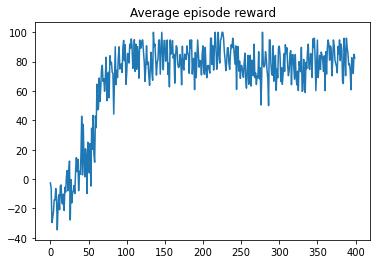

In [6]:
plt.plot(ep_average_rewards)
plt.title('Average episode reward')
plt.show()

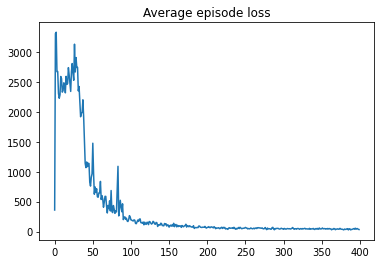

In [7]:
plt.plot(ep_average_losses)
plt.title('Average episode loss')
plt.show()